In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model





In [3]:
corpus=[]
target=[]
edad=[]
sexo=[]
severidad=[]
archivo=open("datasets/dataset_elpino.csv",encoding="utf-8") #pon aqui la ruta de tu dataset siendo el root donde se encuentra este codigo
header=archivo.readline().strip().split(";")
features=[]
for col in header:
    col=col.split("-")[0].strip()
    if col.startswith("Diag") or col.startswith("Proc"):
        col=col.split(" ")
        col=col[0]+col[1]
    features.append(col)
for linea in archivo:
    row=[]
    linea=linea.strip().split(";")
    for i in range(len(linea)):
        col=linea[i].split("-")[0].strip()
        if i==67:
            grd=col
            #target.append(grd[-1])
            target.append(grd)
        elif i==66:
            sexo.append(1 if col=="Mujer" else 0)
        elif i==65:
            edad.append(int(col))
        else:
            row.append(col)
    corpus.append(row)

archivo.close()

In [4]:
df=pd.DataFrame(corpus,columns=features[:-3])
df["GRD"]=target

In [5]:
#Junta todas las columnas de codigos en una sola lista
code_columns = [col for col in df.columns if col.startswith("Diag") or col.startswith("Proc")]

#Aplanar los codigos para construir el vocabulario
all_codes = df[code_columns].values.flatten()
unique_codes = pd.Series(all_codes).dropna().unique().tolist()

In [6]:
#Creacion del vocabulario
lookup_layer = tf.keras.layers.StringLookup(vocabulary=unique_codes, oov_token="[UNK]")

#Codigos a tensores de string y aplica StringLookup
X_codes_str = tf.constant(df[code_columns].astype(str).values)
X_codes_idx = lookup_layer(X_codes_str)

#Padding
X_padded = pad_sequences(X_codes_idx.numpy(), padding='post')

#Codifica los GRD como enteros
grd_lookup = tf.keras.layers.StringLookup(oov_token="[UNK]")
grd_lookup.adapt(df["GRD"])
y = grd_lookup(df["GRD"])

In [73]:
#Separar datos
X_train, X_test, y_train, y_test = train_test_split(X_padded, y.numpy(), test_size=0.3, random_state=42)


#Define modelo en Keras
vocab_size = lookup_layer.vocabulary_size()
num_classes = grd_lookup.vocabulary_size()

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=64),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),  # Dropout en capa densa
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [74]:
#Entrenar modelo
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=30, batch_size=64)

#Evaluar modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy en test: {accuracy:.2%}")

Epoch 1/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.0363 - loss: 5.6747 - val_accuracy: 0.0726 - val_loss: 4.9417
Epoch 2/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.0789 - loss: 4.7843 - val_accuracy: 0.1165 - val_loss: 4.4892
Epoch 3/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.1119 - loss: 4.3542 - val_accuracy: 0.1300 - val_loss: 4.1825
Epoch 4/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.1303 - loss: 4.0999 - val_accuracy: 0.1522 - val_loss: 4.0198
Epoch 5/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.1395 - loss: 3.8792 - val_accuracy: 0.1735 - val_loss: 3.8591
Epoch 6/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.1565 - loss: 3.6666 - val_accuracy: 0.1822 - val_loss: 3.7097
Epoch 7/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.1847 - loss: 3.4977 - val_accuracy: 0.2037 - val_loss: 3.5826
Epoch 8/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.2065 - loss: 3.3554 - val_accu

In [80]:
#Guarda el modelo
model.save("modelo_general_withDropout30epochs.keras")

In [ ]:
#Carga el modelo
#model = load_model('modelo_general_withDropout30epochs.keras')

In [75]:
#Metricas de desempeño
y_pred = model.predict(X_test)
#Convierte predicciones a labels de clase discreta
y_pred_classes = np.argmax(y_pred, axis=1)  # Clase con mayor probabilidad

#Clasificacion
print(f"Reporte clasificacion:\n{classification_report(y_test, y_pred_classes)}")

137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Reporte clasificacion:
              precision    recall  f1-score   support

           1       0.85      0.97      0.91       231
           2       0.89      0.82      0.85       182
           3       0.56      0.93      0.70       162
           4       0.69      0.84      0.76       122
           5       0.78      0.79      0.78        98
           6       0.98      0.86      0.92        95
           7       0.95      0.91      0.93        87
           8       0.98      0.98      0.98        65
           9       0.89      0.89      0.89        72
          10       0.67      0.37      0.48        65
          11       0.82      0.94      0.88        79
          12       0.87      0.88      0.88        78
          13       0.69      0.81      0.74        59
          14       0.83      0.84      0.84        64
          15       0.00      0.00      0.00        54
          16       0.80      0.73      0.76        44
          17     

d:\Users\Intel\Documents\Archivador\Proyectos\Universidad\Aprendizaje de Maquina\Embedding-ML\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Users\Intel\Documents\Archivador\Proyectos\Universidad\Aprendizaje de Maquina\Embedding-ML\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Users\Intel\Documents\Archivador\Proyectos\Universidad\Aprendizaje de Maquina\Embedding-ML\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being 

In [76]:
#Matriz de confusion (sin graficar porque no se ve jaja)
#Obtener predicciones y matriz
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)

#Inicializar totales
TP_total = 0
FP_total = 0
FN_total = 0
TN_total = 0

#Total de clases
num_classes = cm.shape[0]
total_samples = np.sum(cm)

for i in range(num_classes):
    TP = cm[i, i]
    FP = np.sum(cm[:, i]) - TP
    FN = np.sum(cm[i, :]) - TP
    TN = total_samples - TP - FP - FN

    TP_total += TP
    FP_total += FP
    FN_total += FN
    TN_total += TN

print(f"Totales:")
print(f"TP: {TP_total}")
print(f"FP: {FP_total}")
print(f"FN: {FN_total}")
print(f"TN: {TN_total}")

137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Totales:
TP: 2440
FP: 1929
FN: 1929
TN: 1824313


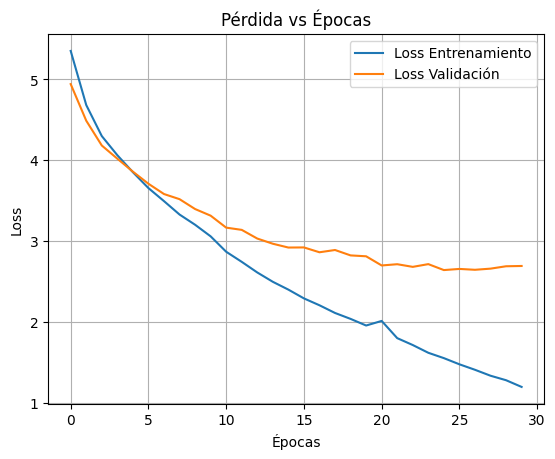

In [77]:
#Grafico epoch vs loss
plt.plot(history.history['loss'], label='Loss Entrenamiento')
plt.plot(history.history['val_loss'], label='Loss Validación')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.title('Pérdida vs Épocas')
plt.grid(True)
plt.show()